# EDA & Preprocessing — Improved

This notebook provides a structured EDA and a robust preprocessing pipeline using `sklearn`.

Key features:
- Safe data loading with basic checks
- Summary statistics and targeted visualizations
- Missing value strategies (column-type aware)
- Outlier handling (optional winsorization)
- Feature engineering suggestions
- ColumnTransformer pipeline with imputation, scaling, and encoding
- Save preprocessing pipeline for reuse


In [57]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Load the dataset
DATA_PATH = '../data/raw/winequality-red.csv'
try:
    df = pd.read_csv(DATA_PATH)
    print('🍷 Wine Quality Dataset Loaded Successfully!')
    print(f'📊 Dataset Shape: {df.shape}')
    print(f'📋 Columns: {list(df.columns)}')
except Exception as e:
    print('Could not load dataset:', e)
    df = None


🍷 Wine Quality Dataset Loaded Successfully!
📊 Dataset Shape: (1599, 12)
📋 Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


## 1) Quick overview and checks

In [58]:
if df is not None:
    display(df.info())
    display(df.describe(include='all').T)
    # missing values
    miss = df.isnull().mean().sort_values(ascending=False)
    display(miss[miss>0].to_frame('missing_frac'))
    # duplicate rows
    print('Duplicates:', df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


,missing_frac


Duplicates: 240


## 2) Target & problem type — confirm task

In [59]:
# Convert quality to binary classification target
if df is not None:
    df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)
    print('✅ Created binary classification target: quality_binary')
    print(df['quality_binary'].value_counts())
    print('\nQuality distribution (%):')
    print(df['quality_binary'].value_counts(normalize=True) * 100)

✅ Created binary classification target: quality_binary
quality_binary
0    1382
1     217
Name: count, dtype: int64

Quality distribution (%):
quality_binary
0    86.429018
1    13.570982
Name: proportion, dtype: float64


## 3) Numerical & Categorical split

In [60]:
if df is not None:
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    # if target is numeric but actually classification, keep it separate
    if TARGET in num_cols:
        num_cols = [c for c in num_cols if c!=TARGET]
    if TARGET in cat_cols:
        cat_cols = [c for c in cat_cols if c!=TARGET]
    print('Numerical columns:', num_cols)
    print('Categorical columns:', cat_cols)


Numerical columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'quality_binary']
Categorical columns: []


## 4) Correlations & quick feature importance (numeric)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_binary
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052,0.120061
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558,-0.270712
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373,0.214716
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732,0.047779
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907,-0.097308
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656,-0.071747
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100,-0.139517
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919,-0.150460
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731,-0.057283
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397,0.199485


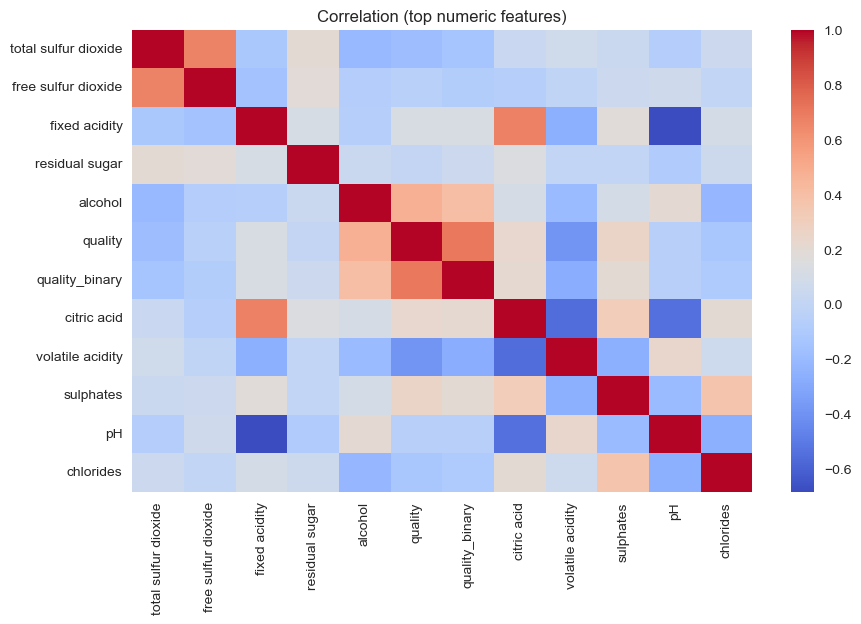

In [61]:
if df is not None and len(num_cols)>0:
    corr = df[num_cols + ([TARGET] if TARGET in df.columns else [])].corr()
    display(corr.abs().sort_values(by=TARGET, ascending=False)[TARGET].to_frame() if TARGET in corr.columns else corr)
    # heatmap for top 12 numeric features by variance
    top_num = df[num_cols].var().sort_values(ascending=False).head(12).index.tolist()
    plt.figure(figsize=(10,6))
    sns.heatmap(df[top_num].corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation (top numeric features)')
    plt.show()


## 5) Missing value handling strategy (column-type aware)

In [62]:
from sklearn.impute import SimpleImputer

# rules:
# - numeric: median
# - low-cardinality categorical (<20 unique): most_frequent
# - high-cardinality categorical: new_category or target encoding (done in training notebook)
def column_impute_suggestions(df):
    suggestions = {}
    for c in df.columns:
        if df[c].isnull().any():
            if pd.api.types.is_numeric_dtype(df[c]):
                suggestions[c] = 'median'
            else:
                nunique = df[c].nunique(dropna=True)
                if nunique <= 20:
                    suggestions[c] = 'most_frequent'
                else:
                    suggestions[c] = 'new_category'
    return suggestions

if df is not None:
    display(column_impute_suggestions(df))


{}

## 6) Preprocessing pipeline (sklearn ColumnTransformer)
This pipeline uses:
- Numeric: SimpleImputer(median) + StandardScaler
- Categorical (low-card): SimpleImputer(mode) + OneHotEncoder(handle_unknown='ignore')
- Categorical (high-card): SimpleImputer('constant', fill_value='__MISSING__') + OrdinalEncoder or LeaveOneOut/Target encoding (recommended in training)

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

def build_preprocessing_pipeline(df, target_col):
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    # split low/high cardinality
    low_card = [c for c in cat_cols if df[c].nunique() <= 20]
    high_card = [c for c in cat_cols if df[c].nunique() > 20]
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    low_card_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    high_card_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('lowcard', low_card_pipeline, low_card),
        ('highcard', high_card_pipeline, high_card)
    ], remainder='drop')
    return preprocessor, num_cols, low_card, high_card

if df is not None:
    preproc, num_cols, low_card, high_card = build_preprocessing_pipeline(df, TARGET)
    print('num:', num_cols)
    print('low_card:', low_card)
    print('high_card sample:', high_card[:5])

num: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'quality_binary']
low_card: []
high_card sample: []


## 7) Save preprocessing pipeline (pickle)

In [64]:
import joblib
import os
PIPE_PATH = '../backend/saved_models/preprocessing_pipeline.joblib'
if df is not None:
    os.makedirs(os.path.dirname(PIPE_PATH), exist_ok=True)
    joblib.dump(preproc, PIPE_PATH)
    print('Saved preprocessing pipeline to', PIPE_PATH)

Saved preprocessing pipeline to ../backend/saved_models/preprocessing_pipeline.joblib


In [65]:
# Feature scaling and save processed dataset
if df is not None:
    # Keep features only
    features = df.drop(['quality', 'quality_binary'], axis=1)
    target = df['quality_binary']

    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Create final dataframe
    scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
    scaled_df['quality_binary'] = target.values

    # Save processed dataset
    os.makedirs('../data/processed', exist_ok=True)
    scaled_df.to_csv('../data/processed/wine_processed.csv', index=False)
    print('💾 Processed dataset saved to ../data/processed/wine_processed.csv')

    # Save preprocessing artifacts
    os.makedirs('../backend/saved_models', exist_ok=True)
    joblib.dump(scaler, '../backend/saved_models/scaler.pkl')
    print('💾 Scaler saved to ../backend/saved_models/scaler.pkl')

💾 Processed dataset saved to ../data/processed/wine_processed.csv
💾 Scaler saved to ../backend/saved_models/scaler.pkl
